In [1]:
import pandas as pd
import numpy as np
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_column', 50)

In [2]:
FOLDERPATH = "./data/"

CATEGORICAL_COLS = ['event_name', 'name','level', 'page', "fullscreen", "hq", "music", 'level_group']
ID_CATEGORICAL_COLS = ['fqid', 'room_fqid', 'text_fqid']

NUMERICAL_COLS = ['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration']

In [3]:
def feature_engineer(dataset_df, time_interval):
    dfs = []
    dataset_df['elapsed_time_bin'] = (dataset_df['elapsed_time'] // time_interval).astype(int)
    for c in CATEGORICAL_COLS:
        tmp = dataset_df.groupby(['session_id', 'elapsed_time_bin', 'level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in ID_CATEGORICAL_COLS:
        tmp = dataset_df.groupby(['session_id','elapsed_time_bin','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    
    for c in NUMERICAL_COLS:
        tmp = dataset_df.groupby(['session_id','elapsed_time_bin','level_group'])[c].agg('mean')
        dfs.append(tmp)
    
    for c in NUMERICAL_COLS:
        tmp = dataset_df.groupby(['session_id','elapsed_time_bin','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [4]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group' : str}

df_train = pd.read_csv(FOLDERPATH + "train.csv", dtype=dtypes)
print(f"The train dataset contains {df_train.shape[0]} rows and {df_train.shape[1]} columns")

df_train.head(10)

The train dataset contains 26296946 rows and 20 columns


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
5,20090312431273200,5,3423,person_click,basic,0,NaN,-412.991394,-157.314682,381.0,492.0,NaN,"Sure thing, Jo. Grab your notebook and come up...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
6,20090312431273200,6,5197,person_click,basic,0,NaN,478.485077,-199.971680,593.0,485.0,NaN,"See you later, Teddy.",teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
7,20090312431273200,7,6180,person_click,basic,0,NaN,503.355133,-168.619919,609.0,453.0,NaN,I get to go to Gramps's meeting!,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
8,20090312431273200,8,7014,person_click,basic,0,NaN,510.733429,-157.720642,615.0,442.0,NaN,Now where did I put my notebook?,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
9,20090312431273200,9,7946,person_click,basic,0,NaN,512.048035,-153.743637,616.0,438.0,NaN,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4


In [5]:
train_labels = pd.read_csv(FOLDERPATH + "train_labels.csv")
print(f"Loading {train_labels.shape[0]} labels.")

print(f"Preprocessing session IDs...")

train_labels['session'] = train_labels.session_id.apply(lambda x: int(x.split('_')[0]) )
train_labels['q'] = train_labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

print(f"Labels contains {train_labels['session'].nunique()} sessions with answers to {train_labels['q'].nunique()} questions which is overall {train_labels.shape[0]} rows.")

train_labels["session_id"] = train_labels["session"]
train_labels = train_labels[["session_id", "q", "correct"]]
train_labels[["session_id", "q", "correct"]].head()
print("Creating pivot table...")
pivot_df = train_labels.pivot_table(index='session_id', columns='q', values='correct', aggfunc='first')
# Rename columns to 'q' followed by the question number
pivot_df.columns = ['q' + str(col) for col in pivot_df.columns]
# Fill NaN values with 0 if needed
pivot_df = pivot_df.fillna(0).reset_index()
pivot_df.head()

Loading 424116 labels.
Preprocessing session IDs...
Labels contains 23562 sessions with answers to 18 questions which is overall 424116 rows.
Creating pivot table...


,session_id,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17,q18
0,20090312431273200,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
1,20090312433251036,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1
2,20090312455206810,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
3,20090313091715820,0,1,1,1,1,0,1,1,1,0,0,1,0,1,0,1,1,1
4,20090313571836404,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1


In [6]:
pivot_df.to_csv("./export/pivot.csv")

In [7]:
def create_feature_from_clicks(fqid, right, out, lots = 10):
    IDX = ((df_train.fqid==fqid))&(df_train.event_name!='navigate_click') & out & right
    tmp = df_train.loc[IDX]
    events_in_room = tmp.groupby(['session_id','elapsed_time_bin'])['index'].count()
    return events_in_room

def preporcess_dataset(interval=10000):
    aggregated_df = feature_engineer(df_train, time_interval=interval).reset_index()
    print(f"dataframe aggregated from {len(df_train)} to: {len(aggregated_df)}")
    aggregated_df['index'] = range(len(aggregated_df))
    
    out = True

    right_tunic = ~((df_train.room_coor_x < 200) & (df_train.room_coor_x > 50 ) & (df_train.room_coor_y < 350) & (df_train.room_coor_y >200))
    right_plaque  = ~((df_train.room_coor_x < 590) & (df_train.room_coor_x > 500 ) & (df_train.room_coor_y < -80) & (df_train.room_coor_y >-150))
    right_businesscards  = ~((df_train.room_coor_x < 150) & (df_train.room_coor_x > 50 ) & (df_train.room_coor_y < -100) & (df_train.room_coor_y >-150))
    right_logbook = ~((df_train.room_coor_y < 40) & (df_train.room_coor_y >-10))
    right_reader = ~((df_train.room_coor_x < -150) & (df_train.room_coor_x > -300 ) & (df_train.room_coor_y < -90) & (df_train.room_coor_y >-120))
    right_directory = ~((df_train.room_coor_x < -60) & (df_train.room_coor_x > -390 ) & (df_train.room_coor_y < -280) & (df_train.room_coor_y >-460))
    right_tracks = ~((df_train.room_coor_x < 1100) & (df_train.room_coor_x > 950 ) & (df_train.room_coor_y < -320) & (df_train.room_coor_y >-500))
    right_colorbook = True
    right_reader_flag = ~((df_train.room_coor_x < 0) & (df_train.room_coor_x > -290 ) & (df_train.room_coor_y < 110) & (df_train.room_coor_y >-90))
    right_journals_flag = True

    FQID = ['tunic', 'plaque','businesscards','logbook','reader','tracks','colorbook','reader_flag','journals_flag']
    RIGHT_FQID =  [right_tunic, right_plaque, right_businesscards, right_logbook, right_reader, right_tracks, right_colorbook, right_reader_flag, right_journals_flag]

    df_clues = pd.DataFrame(aggregated_df.groupby(['session_id','elapsed_time_bin'])['index'].count()).drop(columns = 'index')
    
    for fqid, right in zip(FQID, RIGHT_FQID):
        #(f"Counting {fqid} mistakes...")
        df_clues[f"{fqid}_mistakes"] = create_feature_from_clicks(fqid, right, out)

    df_clues.reset_index(inplace=True)
    df_clues = df_clues.fillna(0)
    # Convert all columns except the first one to integer
    mistake_cols = df_clues.columns[2:].to_list()
    df_clues[mistake_cols] = df_clues[mistake_cols].astype(int)
    prepocessed_df_w_clues = pd.merge(aggregated_df, df_clues, on=['session_id', 'elapsed_time_bin'], how='left')
    prepocessed_df_w_clues.drop(columns="index", inplace=True)
    trainset = pd.merge(prepocessed_df_w_clues, pivot_df, how='left', on="session_id")
    print("Returning training set:", trainset.shape)
    return trainset


def f1_scoring(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_sc = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_sc

In [8]:
trainset = preporcess_dataset(100000)

dataframe aggregated from 26296946 to: 447188
Returning training set: (447188, 53)


In [10]:
trainset.head()

,session_id,elapsed_time_bin,level_group,event_name_nunique,name_nunique,level_nunique,page_nunique,fullscreen_nunique,hq_nunique,music_nunique,level_group_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,elapsed_time_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,...,businesscards_mistakes,logbook_mistakes,reader_mistakes,tracks_mistakes,colorbook_mistakes,reader_flag_mistakes,journals_flag_mistakes,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17,q18
0,20090312431273200,0,0-4,7,3,3,0,1,1,1,1,18,4,14,51858.571429,-26.410358,-72.976036,431.494751,382.410522,4082.666748,30778.083059,380.696381,141.395477,191.233398,108.233543,...,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
1,20090312431273200,1,0-4,10,3,3,0,1,1,1,1,17,7,6,135429.805970,60.825951,-68.980682,474.754089,384.032776,1373.599976,20568.544166,424.395477,108.869713,246.615875,98.140030,...,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
2,20090312431273200,2,5-12,5,3,2,0,1,1,1,1,15,6,8,257251.518519,-82.789146,-123.936050,447.794861,424.487183,560.666687,21880.835101,444.787842,130.644104,195.970337,105.061111,...,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
3,20090312431273200,3,5-12,8,3,4,0,1,1,1,1,18,6,10,348614.618644,62.361244,-25.987761,458.792450,358.603760,736.083313,29581.597693,258.967682,113.852135,197.941193,109.077141,...,2,5,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
4,20090312431273200,4,5-12,8,3,4,0,1,1,1,1,23,6,6,451122.041237,44.918125,-34.008106,447.000000,361.185181,1237.666626,29240.720291,359.831543,150.631622,218.762833,136.356064,...,0,0,4,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1


In [11]:
cols = trainset.columns.to_list()
features = cols[3:-18]

print("Features columns:", features)

Features columns: ['event_name_nunique', 'name_nunique', 'level_nunique', 'page_nunique', 'fullscreen_nunique', 'hq_nunique', 'music_nunique', 'level_group_nunique', 'fqid_nunique', 'room_fqid_nunique', 'text_fqid_nunique', 'elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration', 'elapsed_time_std', 'room_coor_x_std', 'room_coor_y_std', 'screen_coor_x_std', 'screen_coor_y_std', 'hover_duration_std', 'tunic_mistakes', 'plaque_mistakes', 'businesscards_mistakes', 'logbook_mistakes', 'reader_mistakes', 'tracks_mistakes', 'colorbook_mistakes', 'reader_flag_mistakes', 'journals_flag_mistakes']


In [12]:
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.layers import Dot, Softmax, Layer, Reshape
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Softmax, Multiply
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K

from keras.layers import Layer, Dot, Softmax
import keras.backend as K
from tensorflow.keras.layers import Bidirectional

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='W',
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='b',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


# This is NN LSTM Model creation
def model_lstm(input_shape):
    # The shape was explained above, must have this order
    inp = Input(shape=(input_shape[1], input_shape[2],))
    # This is the LSTM layer
    # Bidirecional implies that the 160 chunks are calculated in both ways, 0 to 159 and 159 to zero
    # although it appear that just 0 to 159 way matter, I have tested with and without, and tha later worked best
    # 128 and 64 are the number of cells used, too many can overfit and too few can underfit
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    # The second LSTM can give more fire power to the model, but can overfit it too
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    # Attention is a new tecnology that can be applyed to a Recurrent NN to give more meanings to a signal found in the middle
    # of the data, it helps more in longs chains of data. A normal RNN give all the responsibility of detect the signal
    # to the last cell. Google RNN Attention for more information :)
    x = Attention(input_shape[1])(x)
    # A intermediate full connected (Dense) can help to deal with nonlinears outputs
    x = Dense(64, activation="relu")(x)
    # A binnary classification as this must finish with shape (1,)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    # Pay attention in the addition of matthews_correlation metric in the compilation, it is a success factor key
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_scoring])
    
    return model

In [13]:
from sklearn.linear_model import LogisticRegression

print("Using LogReg\nFiltering for level_qroups:")

logreg_accuracies = []
logreg_f1_scores = []

gbc_accuracies = []
gbc_f1_scores = []

lstm_accuracies = []
lstm_f1_scores = []

lstm_a_accuracies = []
lstm_a_f1_scores = []

for i in range(1, 19):
    question = f"q{i}"
    
    train_session_ids, test_session_ids = train_test_split(pivot_df['session_id'], test_size=0.2, random_state=42, stratify=pivot_df[question])

    X_train = trainset[trainset['session_id'].isin(train_session_ids)]
    X_test = trainset[trainset['session_id'].isin(test_session_ids)]
    if i<=3: grp = '0-4'
    elif i<=13: grp = '5-12'
    elif i<=22: grp = '13-22'
    
    X_train = X_train.loc[X_train.level_group == grp]
    X_test = X_test.loc[X_test.level_group == grp]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[features])
    X_test_scaled = scaler.transform(X_test[features])
    y_train = X_train[question]
    y_test = X_test[question]

    # Create and train the logistic regression model
    lr_model = LogisticRegression()
    lr_model.fit(X_train_scaled, y_train)
    
    # Evaluate the Logreg model
    accuracy = lr_model.score(X_test_scaled, y_test)
    predictions = lr_model.predict(X_test_scaled)
    f1 = f1_score(y_test, predictions)

    print("\tLogreg F1 Score:", f1)
    print("\tLogreg Accuracy:", accuracy)
    logreg_accuracies.append(accuracy)
    logreg_f1_scores.append(f1)
    
    # Evaluate the GradientBoostingClassifier model
    gbr_model = GradientBoostingClassifier()
    gbr_model.fit(X_train_scaled, y_train)

    # Evaluate the model
    accuracy = gbr_model.score(X_test_scaled, y_test)
    predictions = gbr_model.predict(X_test_scaled)
    f1 = f1_score(y_test, predictions)

    print("\tGradientBoostingClassifier F1 Score:", f1)
    print("\tGradientBoostingClassifier Accuracy:", accuracy)
    gbc_accuracies.append(accuracy)
    gbc_f1_scores.append(f1)
    
    
    model = Sequential([
        LSTM(64, input_shape=(X_train_scaled.shape[1], 1)),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_scoring])
    timesteps = 32
    # Reshape features for LSTM input (add a new axis for time steps)
    X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, 1)
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, 1)

    # Train the model
    history = model.fit(X_train_reshaped, y_train, epochs=2, batch_size=64, validation_data=(X_test_reshaped, y_test))

    predictions = model.predict(X_test_reshaped)
    accuracy = accuracy_score(X_test[question], (predictions > 0.5).astype(int))
    # Calculate F1 score
    f1 = f1_score(X_test[question], (predictions > 0.5).astype(int))
    print("\tLSTM F1 Score:", f1)
    print("\tLSTM Accuracy:", accuracy)
    lstm_accuracies.append(accuracy)
    lstm_f1_scores.append(f1)
    
    
    model = model_lstm(X_train_reshaped.shape)
    
    model.fit(X_train_reshaped, y_train, batch_size=64, epochs=2, validation_data=[X_test_reshaped, y_test])
    predictions = model.predict(X_test_reshaped)
    accuracy = accuracy_score(X_test[question], (predictions > 0.5).astype(int))
    # Calculate F1 score
    f1 = f1_score(X_test[question], (predictions > 0.5).astype(int))
    print("\tLSTM Attention F1 Score:", f1)
    print("\tLSTM Attention Accuracy:", accuracy)
    lstm_a_accuracies.append(accuracy)
    lstm_a_f1_scores.append(f1)

Using LogReg
Filtering for level_qroups:
	Logreg F1 Score: 0.8257550614005975
	Logreg Accuracy: 0.7046136534133534
	GradientBoostingClassifier F1 Score: 0.8259682773884176
	GradientBoostingClassifier Accuracy: 0.705051262815704
Epoch 1/2
1011/1011 [==============================] - 19s 16ms/step - loss: 0.6072 - f1_scoring: 0.8249 - val_loss: 0.6051 - val_f1_scoring: 0.8194
Epoch 2/2
500/500 [==============================] - 3s 4ms/step
	LSTM F1 Score: 0.826069395997797
	LSTM Accuracy: 0.7038634658664666
Epoch 1/2
1011/1011 [==============================] - 82s 73ms/step - loss: 0.6072 - f1_scoring: 0.8247 - val_loss: 0.6048 - val_f1_scoring: 0.8195
Epoch 2/2
500/500 [==============================] - 9s 14ms/step
	LSTM Attention F1 Score: 0.8259816513761469
	LSTM Attention Accuracy: 0.7035508877219305


c:\Users\meste\anaconda3\envs\keras\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	Logreg F1 Score: 0.9878675196168026
	Logreg Accuracy: 0.9760259044772401
	GradientBoostingClassifier F1 Score: 0.987579597755501
	GradientBoostingClassifier Accuracy: 0.9754654710754094
Epoch 1/2
1010/1010 [==============================] - 15s 13ms/step - loss: 0.1229 - f1_scoring: 0.9869 - val_loss: 0.1131 - val_f1_scoring: 0.9874
Epoch 2/2
502/502 [==============================] - 3s 4ms/step
	LSTM F1 Score: 0.9878675196168026
	LSTM Accuracy: 0.9760259044772401
Epoch 1/2
1010/1010 [==============================] - 84s 76ms/step - loss: 0.1205 - f1_scoring: 0.9874 - val_loss: 0.1141 - val_f1_scoring: 0.9874
Epoch 2/2
502/502 [==============================] - 9s 15ms/step
	LSTM Attention F1 Score: 0.9878675196168026
	LSTM Attention Accuracy: 0.9760259044772401
	Logreg F1 Score: 0.961695296195216
	Logreg Accuracy: 0.926221397649969
	GradientBoostingClassifier F1 Score: 0.961459403905447
	GradientBoostingClassifier Accuracy: 0.9257884972170687
Epoch 1/2
1009/1009 [==================

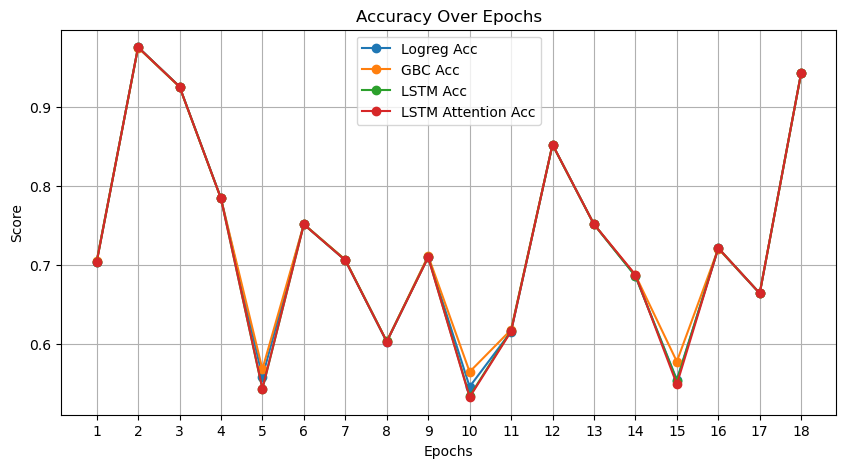

In [14]:
import matplotlib.pyplot as plt

# List of epochs (assuming each value corresponds to an epoch)
epochs = list(range(1, len(logreg_f1_scores) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, logreg_accuracies, label='Logreg Acc', marker='o')
plt.plot(epochs, gbc_accuracies, label='GBC Acc', marker='o')
plt.plot(epochs, lstm_accuracies, label='LSTM Acc', marker='o')
plt.plot(epochs, lstm_a_accuracies, label='LSTM Attention Acc', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Accuracy Over Epochs')
plt.xticks(epochs)

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()


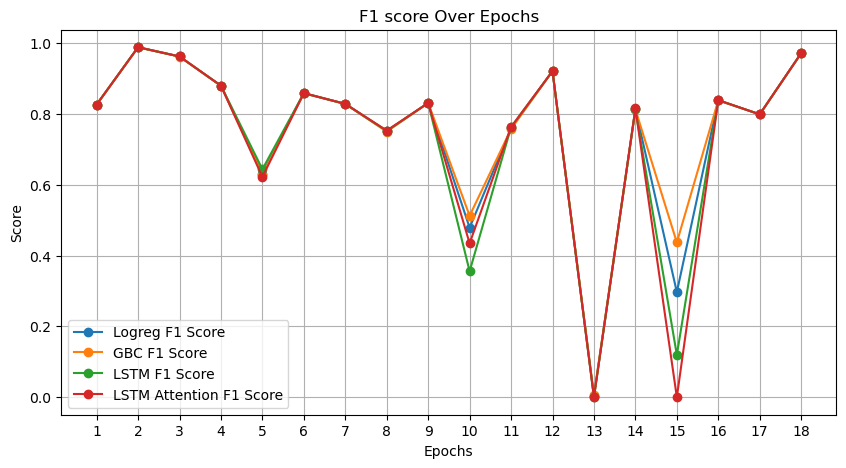

In [15]:
import matplotlib.pyplot as plt

# List of epochs (assuming each value corresponds to an epoch)
epochs = list(range(1, len(logreg_f1_scores) + 1))

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, logreg_f1_scores, label='Logreg F1 Score', marker='o')
plt.plot(epochs, gbc_f1_scores, label='GBC F1 Score', marker='o')
plt.plot(epochs, lstm_f1_scores, label='LSTM F1 Score', marker='o')
plt.plot(epochs, lstm_a_f1_scores, label='LSTM Attention F1 Score', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('F1 score Over Epochs')
plt.xticks(epochs)

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()
